 **Facial Keypoint Detection**          
 First of all let's discuss what we are given.        
We are given three CSV files.        
training.csv :- Its has coordinates of facial keypoints like left eye, rigth eye etc and also the image.      
test.csv :- Its has image only and we have to give coordinates of various facial keypoints by looking at third csv file which is IdLookupTable.csv     
Rest everything is explained below.      
**I would really appreciate if you could upvote this kernel.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

In [2]:
Train_Dir = '/Users/szkfzx/datasets/FaceDetection/training.csv'
Test_Dir = '/Users/szkfzx/datasets/FaceDetection/test.csv'
lookid_dir = '/Users/szkfzx/datasets/FaceDetection/IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
os.listdir('/Users/szkfzx/datasets/FaceDetection')

['training.csv',
 'IdLookupTable.csv',
 '.DS_Store',
 'SampleSubmission.csv',
 'test.csv']

Lets explore our dataset

In [3]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Lets check for missing values

In [4]:
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

So there are missing values in 28 columns. We can do two things here one remove the rows having missing values and another is the fill missing values with something. I used two option as removing rows will reduce our dataset. 
I filled the missing values with the previous values in that row.

In [5]:

train_data.fillna(method = 'ffill',inplace = True)
#train_data.reset_index(drop = True,inplace = True)


Lets check for missing values now

In [6]:
train_data.isnull().any().value_counts()

False    31
dtype: int64

As there is no missing values we can now separate the labels and features.
The image is our feature and other values are labes that we have to predict later.
As image column values are in string format and there is also some missing values so we have to split the string by space and append it and also handling missing values

In [7]:

imag = []
for i in range(0,7049):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)
    
    

Lets reshape and convert it into float value.

In [8]:
image_list = np.array(imag,dtype = 'float')
X_train = image_list.reshape(-1,96,96)



Lets see what is the first image.

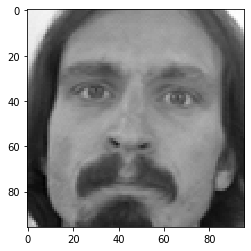

In [9]:
plt.imshow(X_train[0],cmap='gray')
plt.show()

Now lets separate labels.

In [10]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')



As our data is ready for training , lets define our model. I am using keras and simple dense layers. For loss function I am using 'mse' ( mean squared error ) as we have to predict new values. Our result evaluted on the basics of 'mae' ( mean absolute error ) . 

In [11]:
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential

model = Sequential([Flatten(input_shape=(96,96)),
                         Dense(128, activation="relu"),
                         Dropout(0.1),
                         Dense(64, activation="relu"),
                         Dense(30)
                         ])

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now our model is defined and we will train it by calling fit method. I ran it for 500 iteration keeping batch size and validtion set size as 20% ( 20% of the training data will be kept for validating the model ).

In [12]:
model.fit(X_train,y_train,epochs = 500,batch_size = 128,validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 5639 samples, validate on 1410 samples
Epoch 1/500
5639/5639 [==============================] - 1s 210us/step - loss: 14727.7755 - mean_absolute_error: 73.3077 - acc: 0.1076 - val_loss: 1582.0830 - val_mean_absolute_error: 34.2163 - val_acc: 0.1809
Epoch 2/500
5639/5639 [==============================] - 1s 135us/step - loss: 1111.5599 - mean_absolute_error: 26.6232 - acc: 0.2305 - val_loss: 358.9781 - val_mean_absolute_error: 14.9321 - val_acc: 0.2525
Epoch 3/500
5639/5639 [==============================] - 1s 134us/step - loss: 411.3437 - mean_absolute_error: 14.3535 - acc: 0.3584 - val_loss: 190.3776 - val_mean_absolute_error: 10.5374 - val_acc: 0.6220
Epoch 4/500
5639/5639 [==============================] - 1s 135us/step - loss: 360.5490 - mean_absolute_error: 12.7238 - acc: 0.4341 - val_loss: 159.9579 - val_mean_absolute_error: 9.3793 - val_acc: 0.3411
Epoch 5/500
5639/5639 [==============================] - 1s 134us/step - 

5639/5639 [==============================] - 1s 142us/step - loss: 130.3636 - mean_absolute_error: 8.0621 - acc: 0.5361 - val_loss: 119.0818 - val_mean_absolute_error: 7.9577 - val_acc: 0.4638
Epoch 40/500
5639/5639 [==============================] - 1s 138us/step - loss: 122.1556 - mean_absolute_error: 7.7692 - acc: 0.5361 - val_loss: 111.4838 - val_mean_absolute_error: 7.8171 - val_acc: 0.6851
Epoch 41/500
5639/5639 [==============================] - 1s 138us/step - loss: 122.5124 - mean_absolute_error: 7.8762 - acc: 0.5554 - val_loss: 118.5349 - val_mean_absolute_error: 8.0409 - val_acc: 0.6851
Epoch 42/500
5639/5639 [==============================] - 1s 141us/step - loss: 143.5801 - mean_absolute_error: 8.5411 - acc: 0.5302 - val_loss: 110.4032 - val_mean_absolute_error: 7.7553 - val_acc: 0.6865
Epoch 43/500
5639/5639 [==============================] - 1s 141us/step - loss: 134.2841 - mean_absolute_error: 8.2042 - acc: 0.5347 - val_loss: 124.1008 - val_mean_absolute_error: 8.2518 -

Epoch 79/500
5639/5639 [==============================] - 1s 133us/step - loss: 122.7564 - mean_absolute_error: 7.7131 - acc: 0.5251 - val_loss: 236.5007 - val_mean_absolute_error: 12.5146 - val_acc: 0.6574
Epoch 80/500
5639/5639 [==============================] - 1s 140us/step - loss: 125.3182 - mean_absolute_error: 7.9869 - acc: 0.5137 - val_loss: 182.3673 - val_mean_absolute_error: 10.4612 - val_acc: 0.6553
Epoch 81/500
5639/5639 [==============================] - 1s 139us/step - loss: 120.7209 - mean_absolute_error: 7.7299 - acc: 0.5540 - val_loss: 154.8424 - val_mean_absolute_error: 9.5157 - val_acc: 0.6113
Epoch 82/500
5639/5639 [==============================] - 1s 138us/step - loss: 110.1273 - mean_absolute_error: 7.3243 - acc: 0.5462 - val_loss: 112.9490 - val_mean_absolute_error: 7.7820 - val_acc: 0.4355
Epoch 83/500
5639/5639 [==============================] - 1s 135us/step - loss: 111.2436 - mean_absolute_error: 7.3443 - acc: 0.5265 - val_loss: 118.4196 - val_mean_absolute_

Epoch 119/500
5639/5639 [==============================] - 1s 139us/step - loss: 97.9316 - mean_absolute_error: 6.9716 - acc: 0.5607 - val_loss: 186.9077 - val_mean_absolute_error: 10.9079 - val_acc: 0.6667
Epoch 120/500
5639/5639 [==============================] - 1s 138us/step - loss: 97.1319 - mean_absolute_error: 6.8362 - acc: 0.5689 - val_loss: 92.6185 - val_mean_absolute_error: 7.0099 - val_acc: 0.6766
Epoch 121/500
5639/5639 [==============================] - 1s 137us/step - loss: 104.1603 - mean_absolute_error: 7.2025 - acc: 0.5490 - val_loss: 99.0270 - val_mean_absolute_error: 7.1915 - val_acc: 0.6837
Epoch 122/500
5639/5639 [==============================] - 1s 148us/step - loss: 92.3164 - mean_absolute_error: 6.7665 - acc: 0.5643 - val_loss: 92.2990 - val_mean_absolute_error: 6.9163 - val_acc: 0.6865
Epoch 123/500
5639/5639 [==============================] - 1s 147us/step - loss: 97.7755 - mean_absolute_error: 6.9305 - acc: 0.5652 - val_loss: 104.3219 - val_mean_absolute_err

Epoch 159/500
5639/5639 [==============================] - 1s 130us/step - loss: 90.0172 - mean_absolute_error: 6.8149 - acc: 0.5444 - val_loss: 118.6148 - val_mean_absolute_error: 8.1919 - val_acc: 0.6865
Epoch 160/500
5639/5639 [==============================] - 1s 130us/step - loss: 95.5922 - mean_absolute_error: 7.1340 - acc: 0.5387 - val_loss: 81.4240 - val_mean_absolute_error: 6.4978 - val_acc: 0.6865
Epoch 161/500
5639/5639 [==============================] - 1s 129us/step - loss: 77.3702 - mean_absolute_error: 6.3266 - acc: 0.5678 - val_loss: 94.6151 - val_mean_absolute_error: 7.0615 - val_acc: 0.5993
Epoch 162/500
5639/5639 [==============================] - 1s 130us/step - loss: 75.7584 - mean_absolute_error: 6.2015 - acc: 0.5512 - val_loss: 106.4563 - val_mean_absolute_error: 7.6217 - val_acc: 0.6865
Epoch 163/500
5639/5639 [==============================] - 1s 130us/step - loss: 78.7544 - mean_absolute_error: 6.3843 - acc: 0.5577 - val_loss: 157.8091 - val_mean_absolute_erro

Epoch 199/500
5639/5639 [==============================] - 1s 138us/step - loss: 55.5371 - mean_absolute_error: 5.4047 - acc: 0.5614 - val_loss: 81.7126 - val_mean_absolute_error: 6.5159 - val_acc: 0.6858
Epoch 200/500
5639/5639 [==============================] - 1s 142us/step - loss: 56.9662 - mean_absolute_error: 5.4986 - acc: 0.5559 - val_loss: 74.3058 - val_mean_absolute_error: 6.3255 - val_acc: 0.6865
Epoch 201/500
5639/5639 [==============================] - 1s 135us/step - loss: 58.1854 - mean_absolute_error: 5.5911 - acc: 0.5581 - val_loss: 85.5797 - val_mean_absolute_error: 6.7319 - val_acc: 0.6738
Epoch 202/500
5639/5639 [==============================] - 1s 135us/step - loss: 72.9264 - mean_absolute_error: 6.3289 - acc: 0.5178 - val_loss: 93.1956 - val_mean_absolute_error: 7.0569 - val_acc: 0.6759
Epoch 203/500
5639/5639 [==============================] - 1s 137us/step - loss: 52.0497 - mean_absolute_error: 5.2329 - acc: 0.5611 - val_loss: 77.5993 - val_mean_absolute_error: 

Epoch 239/500
5639/5639 [==============================] - 1s 130us/step - loss: 34.4229 - mean_absolute_error: 4.1926 - acc: 0.6391 - val_loss: 68.3029 - val_mean_absolute_error: 5.6960 - val_acc: 0.6440
Epoch 240/500
5639/5639 [==============================] - 1s 131us/step - loss: 33.7354 - mean_absolute_error: 4.1352 - acc: 0.6386 - val_loss: 61.4659 - val_mean_absolute_error: 5.2879 - val_acc: 0.6426
Epoch 241/500
5639/5639 [==============================] - 1s 129us/step - loss: 32.2194 - mean_absolute_error: 4.0413 - acc: 0.6354 - val_loss: 133.7458 - val_mean_absolute_error: 9.0311 - val_acc: 0.6695
Epoch 242/500
5639/5639 [==============================] - 1s 130us/step - loss: 42.6471 - mean_absolute_error: 4.6587 - acc: 0.5930 - val_loss: 67.2197 - val_mean_absolute_error: 5.4647 - val_acc: 0.6844
Epoch 243/500
5639/5639 [==============================] - 1s 129us/step - loss: 35.7734 - mean_absolute_error: 4.2400 - acc: 0.6044 - val_loss: 94.2109 - val_mean_absolute_error:

Epoch 279/500
5639/5639 [==============================] - 1s 132us/step - loss: 18.6402 - mean_absolute_error: 2.9655 - acc: 0.6031 - val_loss: 68.0939 - val_mean_absolute_error: 3.6032 - val_acc: 0.6794
Epoch 280/500
5639/5639 [==============================] - 1s 133us/step - loss: 17.9928 - mean_absolute_error: 2.9108 - acc: 0.6042 - val_loss: 76.1581 - val_mean_absolute_error: 4.3365 - val_acc: 0.6695
Epoch 281/500
5639/5639 [==============================] - 1s 135us/step - loss: 18.0334 - mean_absolute_error: 2.9159 - acc: 0.6037 - val_loss: 58.2750 - val_mean_absolute_error: 3.1661 - val_acc: 0.6752
Epoch 282/500
5639/5639 [==============================] - 1s 135us/step - loss: 18.5444 - mean_absolute_error: 2.9563 - acc: 0.6040 - val_loss: 57.3366 - val_mean_absolute_error: 3.0916 - val_acc: 0.6801
Epoch 283/500
5639/5639 [==============================] - 1s 132us/step - loss: 18.2924 - mean_absolute_error: 2.9540 - acc: 0.6038 - val_loss: 62.2608 - val_mean_absolute_error: 

Epoch 319/500
5639/5639 [==============================] - 1s 140us/step - loss: 10.9126 - mean_absolute_error: 2.1768 - acc: 0.6052 - val_loss: 82.5528 - val_mean_absolute_error: 2.4266 - val_acc: 0.6865
Epoch 320/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.7720 - mean_absolute_error: 2.1657 - acc: 0.6052 - val_loss: 86.1585 - val_mean_absolute_error: 2.6437 - val_acc: 0.6865
Epoch 321/500
5639/5639 [==============================] - 1s 132us/step - loss: 11.1474 - mean_absolute_error: 2.2199 - acc: 0.6052 - val_loss: 81.0141 - val_mean_absolute_error: 2.0878 - val_acc: 0.6865
Epoch 322/500
5639/5639 [==============================] - 1s 134us/step - loss: 10.6958 - mean_absolute_error: 2.1582 - acc: 0.6052 - val_loss: 81.3031 - val_mean_absolute_error: 2.0133 - val_acc: 0.6865
Epoch 323/500
5639/5639 [==============================] - 1s 129us/step - loss: 10.4842 - mean_absolute_error: 2.1226 - acc: 0.6052 - val_loss: 81.1241 - val_mean_absolute_error: 

5639/5639 [==============================] - 1s 139us/step - loss: 9.1208 - mean_absolute_error: 1.8850 - acc: 0.6639 - val_loss: 91.8486 - val_mean_absolute_error: 1.7109 - val_acc: 0.6291
Epoch 360/500
5639/5639 [==============================] - 1s 139us/step - loss: 9.1432 - mean_absolute_error: 1.8917 - acc: 0.6647 - val_loss: 90.5069 - val_mean_absolute_error: 1.6143 - val_acc: 0.6397
Epoch 361/500
5639/5639 [==============================] - 1s 136us/step - loss: 9.0889 - mean_absolute_error: 1.8749 - acc: 0.6726 - val_loss: 90.0891 - val_mean_absolute_error: 1.6970 - val_acc: 0.6149
Epoch 362/500
5639/5639 [==============================] - 1s 133us/step - loss: 9.1319 - mean_absolute_error: 1.8816 - acc: 0.6787 - val_loss: 92.5052 - val_mean_absolute_error: 1.9766 - val_acc: 0.5993
Epoch 363/500
5639/5639 [==============================] - 1s 134us/step - loss: 9.3224 - mean_absolute_error: 1.9472 - acc: 0.6627 - val_loss: 90.8666 - val_mean_absolute_error: 1.6787 - val_acc: 0

5639/5639 [==============================] - 1s 134us/step - loss: 8.9946 - mean_absolute_error: 1.8690 - acc: 0.7010 - val_loss: 90.8395 - val_mean_absolute_error: 1.6900 - val_acc: 0.6092
Epoch 400/500
5639/5639 [==============================] - 1s 133us/step - loss: 8.8668 - mean_absolute_error: 1.8306 - acc: 0.7019 - val_loss: 90.9017 - val_mean_absolute_error: 1.7726 - val_acc: 0.6362
Epoch 401/500
5639/5639 [==============================] - 1s 133us/step - loss: 9.0974 - mean_absolute_error: 1.9001 - acc: 0.6921 - val_loss: 91.5128 - val_mean_absolute_error: 1.8209 - val_acc: 0.5660
Epoch 402/500
5639/5639 [==============================] - 1s 138us/step - loss: 9.7620 - mean_absolute_error: 1.9718 - acc: 0.6221 - val_loss: 93.3656 - val_mean_absolute_error: 1.7634 - val_acc: 0.6865
Epoch 403/500
5639/5639 [==============================] - 1s 133us/step - loss: 10.0738 - mean_absolute_error: 2.0367 - acc: 0.6052 - val_loss: 93.1237 - val_mean_absolute_error: 1.5972 - val_acc: 

5639/5639 [==============================] - 1s 133us/step - loss: 10.0634 - mean_absolute_error: 2.0223 - acc: 0.6052 - val_loss: 93.2841 - val_mean_absolute_error: 1.6867 - val_acc: 0.6865
Epoch 440/500
5639/5639 [==============================] - 1s 129us/step - loss: 10.0704 - mean_absolute_error: 2.0321 - acc: 0.6052 - val_loss: 93.1528 - val_mean_absolute_error: 1.6316 - val_acc: 0.6865
Epoch 441/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0666 - mean_absolute_error: 2.0177 - acc: 0.6052 - val_loss: 93.1965 - val_mean_absolute_error: 1.6768 - val_acc: 0.6865
Epoch 442/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0685 - mean_absolute_error: 2.0261 - acc: 0.6052 - val_loss: 93.3513 - val_mean_absolute_error: 1.6248 - val_acc: 0.6865
Epoch 443/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0947 - mean_absolute_error: 2.0287 - acc: 0.6052 - val_loss: 93.3819 - val_mean_absolute_error: 1.6148 - val_a

5639/5639 [==============================] - 1s 136us/step - loss: 10.0630 - mean_absolute_error: 2.0211 - acc: 0.6052 - val_loss: 93.2654 - val_mean_absolute_error: 1.6916 - val_acc: 0.6865
Epoch 480/500
5639/5639 [==============================] - 1s 141us/step - loss: 10.0658 - mean_absolute_error: 2.0223 - acc: 0.6052 - val_loss: 93.2474 - val_mean_absolute_error: 1.7067 - val_acc: 0.6865
Epoch 481/500
5639/5639 [==============================] - 1s 134us/step - loss: 10.0661 - mean_absolute_error: 2.0248 - acc: 0.6052 - val_loss: 93.1959 - val_mean_absolute_error: 1.6826 - val_acc: 0.6865
Epoch 482/500
5639/5639 [==============================] - 1s 135us/step - loss: 10.0696 - mean_absolute_error: 2.0245 - acc: 0.6052 - val_loss: 93.4159 - val_mean_absolute_error: 1.7765 - val_acc: 0.6865
Epoch 483/500
5639/5639 [==============================] - 1s 134us/step - loss: 10.0789 - mean_absolute_error: 2.0327 - acc: 0.6052 - val_loss: 93.2771 - val_mean_absolute_error: 1.6983 - val_a

Now lets prepare our testing data

In [13]:
#preparing test data
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

Reshaping and converting 

In [14]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96)

Lets see first image in out test data

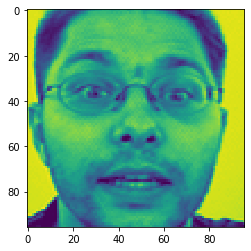

In [15]:
plt.imshow(X_test[0])
plt.show()

Lets predict our results

In [16]:
pred = model.predict(X_test)

Now the last step is the create our submission file keeping in the mind required format.
There should be two columns :- RowId and Location
Location column values should be filled according the lookup table provided ( IdLookupTable.csv)


In [17]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [18]:
rowid = lookid_data['RowId']
rowid=list(rowid)

In [19]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [20]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [21]:
rowid = pd.Series(rowid,name = 'RowId')

In [22]:
loc = pd.Series(preded,name = 'Location')

In [23]:
submission = pd.concat([rowid,loc],axis = 1)


In [24]:
submission.to_csv('face_key_detection_submission.csv',index = False)